# Introdução

O presente projeto, na parte do processamento digital da informação, tem como foco a análise de sentimentos com base em expressões faciais das pessoas. O objetivo principal é desenvolver um sistema capaz de identificar e categorizar as emoções das pessoas a partir de suas expressões faciais. Utilizando técnicas de processamento de imagem, como segmentação, remoção de ruídos, equalização e filtros de média, foram aplicadas preparações nas imagens para padronizar as imagens e treinar uma rede neural para a classificação das emoções.

## Objetivo do Trabalho

O principal objetivo deste trabalho é aplicar técnicas de processamento de imagem para desenvolver uma CNN (Convolutional Neural Network) para a análise de sentimentos baseada em expressões faciais. Para isso, temos os seguintes objetivos:
- Aplicar técnicas de pré-processamento de imagens para melhorar a nitidez, qualidade, remoção de ruídos e segmentação da imagem.
- Treinar um modelo de aprendizado capaz de identificar e classificar diferentes emoções a partir de imagens faciais.
- Avaliar o desempenho do modelo em um conjunto de dados de teste e analisar suas métricas de desempenho.

## Cenário de Aplicação (CA)

### Contextualização
O projeto de análise de sentimentos baseado em expressões faciais é desenvolvido com o propósito de proporcionar uma solução versátil e valiosa para compreender as emoções dos usuários em uma variedade de contextos e setores..

### Funcionamento do Sistema
O funcionamento do sistema é projetado para ser simples e intuitivo, permitindo que até mesmo usuários leigos possam operá-lo facilmente. O processo de operação do sistema pode ser dividido nas seguintes etapas:
1. **Captura de Imagem Facial:** O usuário fornece uma imagem facial ao sistema, que pode ser obtida por meio de uma câmera integrada, webcam ou carregada a partir de um arquivo.
2. **Análise de Expressão Facial:** O sistema utiliza algoritmos de visão computacional e aprendizado profundo para analisar a expressão facial na imagem fornecida.
3. **Classificação de Emoções:** Com base na análise da expressão facial, o sistema classifica a emoção predominante da pessoa na imagem, como felicidade, tristeza, raiva, surpresa, entre outras.
4. **Exibição dos Resultados:** O resultado da análise, incluindo a emoção identificada e possíveis métricas de confiança, é apresentado ao usuário de forma clara e compreensível.

Com essa abordagem simples e eficaz, a aplicação de análise de sentimentos baseado em expressões faciais pode ser facilmente integrado em diferentes cenários de aplicação, fornecendo insights valiosos sobre o estado emocional dos indivíduos.

## Redes Neurais Convolucionais

As Redes Neurais Convolucionais (conhecidas como Convolutional Neural Networks, ou CNNs) são um tipo de rede neural adaptada para processamento de dados não estruturados, como imagens. São compostas pelas seguintes camadas:
* **Camadas Convolucionais:** nessas camadas, são aplicados filtros de convolução às imagens de entrada. Cada filtro detecta padrões específicos, como bordas, texturas ou formas, criando mapas de características. Durante o treinamento, os pesos dos filtros são ajustados para aprender representações relevantes dos dados. Essas camadas ajudam a rede a aprender características importantes das imagens, enquanto mantêm a localidade espacial das informações.
* **Camadas de Pooling:** após as camadas convolucionais, geralmente são inseridas camadas de pooling. O pooling reduz a dimensionalidade dos mapas de características, diminuindo o número de parâmetros da rede e tornando-a mais eficiente computacionalmente. O pooling geralmente é feito através de operações como máximo ou média, reduzindo o tamanho da imagem e, ao mesmo tempo, preservando as características mais importantes.
* **Camadas Conectadas (Fully Connected Layers):** semelhantes às camadas de redes neurais tradicionais, realizam a classificação das imagens com base na saída fornecida após as etapas anteriores.

# Desenvolvimento da aplicação

## Instalação e importação das bibliotecas usadas

In [ ]:
!pip install -q opencv-python
!pip install -q scikit-learn
!pip install -q matplotlib
!pip install -q tensorflow
!pip install -q scikit-image 
!pip install setuptools

print("Libs instaladas")

In [ ]:
# download _morph.py from drive
!pip install -U -q --no-cache-dir gdown --pre 
!gdown --id -q 1FlMtAkb0npwmD54aCysLsxB84PehcKMe

In [1]:
import os
import cv2 as cv
import urllib.request
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow import keras
from keras.models import Model, load_model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing.image import img_to_array, load_img
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from _morph import *

## Pré-processamento das imagens usadas para treinamento

Nesta sessão foram usada as seguintes técnicas de processamento:
- Segmentação do rosto da pessoa
- Remoção de ruídos usando filtro de média
- Reace dos detalhes
- Equalização das imagens


In [2]:
# Baixar arquivo XML do classificador em cascata para identificar rosto
def download_cascade_classifier(url, filename):
    print("Baixando o classificador em cascata...")
    urllib.request.urlretrieve(url, filename)
    print("Download concluído.")

# URL
cascade_url = 'https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml'
cascade_filename = 'haarcascade_frontalface_default.xml'

if not os.path.exists(cascade_filename):
    download_cascade_classifier(cascade_url, cascade_filename)

# Cortar o rosto da imagem
def cut_face(img): 
    face_cascade = cv.CascadeClassifier(cascade_filename)
    if face_cascade.empty():
        raise FileNotFoundError("Erro: Não foi possível carregar o classificador em cascata.")
    
    faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=9)

    for (x, y, w, h) in faces:
        face_roi = img[y:y+h, x:x+w]
    return face_roi

def improve_quality(img):
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(img)

    kernel_sharpening = np.array([[-1,-1,-1],
                                  [-1, 9,-1],
                                  [-1,-1,-1]])
    img_final = cv.filter2D(img_clahe, -1, kernel_sharpening)
    return img_final

# Pré-processar a imagem
def preprocess(image):
    image = cv.resize(image, (224, 224))

    image = cv.medianBlur(image, 3)

    image = mm.color(image)

    image = mm.gray(image)

    image = improve_quality(image)

    image = cv.equalizeHist(image)

    return image

In [3]:
diretorio_entrada = "images/"
diretorio_saida = "preprocessadas/"

emotions = os.listdir(diretorio_entrada)

for emocao in emotions:
    diretorio_emocao_entrada = os.path.join(diretorio_entrada, emocao)
    diretorio_emocao_saida = os.path.join(diretorio_saida, emocao)

    if not os.path.exists(diretorio_emocao_saida):
        os.makedirs(diretorio_emocao_saida)

    imagens = os.listdir(diretorio_emocao_entrada)

    for imagem_nome in imagens:
        caminho_imagem_entrada = os.path.join(diretorio_emocao_entrada, imagem_nome)
        caminho_imagem_saida = os.path.join(diretorio_emocao_saida, imagem_nome)

        imagem = cv.imread(caminho_imagem_entrada)

        imagem_preprocessada = preprocess(imagem)
 
        cv.imwrite(caminho_imagem_saida, imagem_preprocessada)

print("Pré-processamento concluído.")

Pré-processamento concluído.


## Exemplo de imagens de cada emoção

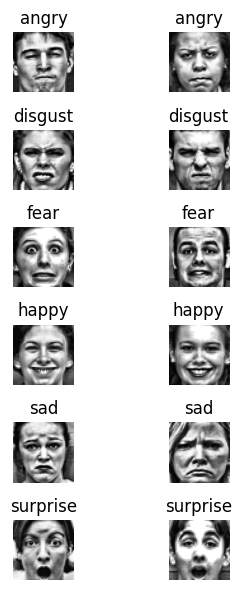

In [4]:
num_examples_per_emotion = 2


num_rows = len(emotions)
num_cols = num_examples_per_emotion
plt.figure(figsize=(4, 6))

for i, emotion in enumerate(emotions):
    emotion_path = os.path.join(diretorio_saida, emotion)

    selected_image_paths = np.random.choice([os.path.join(emotion_path, file) for file in os.listdir(emotion_path)], num_examples_per_emotion, replace=False)

    for j, image_path in enumerate(selected_image_paths):
        image = cv.imread(image_path)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        plt.subplot(num_rows, num_cols, i * num_cols + j + 1)
        plt.imshow(image)
        plt.title(emotion)
        plt.axis('off')

plt.tight_layout()
plt.show()


## Criação do Modelo de classificação

### Separando dados de treinamento e teste

In [5]:
image_paths = []
labels = []
emotion_mapping = {
    'angry': 0,
    'disgust': 1,
    'fear': 2,
    'happy': 3,
    'sad': 4,
    'surprise': 5
}

for emotion, label in emotion_mapping.items():
    expression_path = os.path.join(diretorio_saida, emotion)
    if os.path.exists(expression_path):

        image_paths.extend([os.path.join(expression_path, filename) for filename in os.listdir(expression_path)])
        labels.extend([label] * len(os.listdir(expression_path)))

train_images, test_images, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.3, random_state=42)

print(f"Total de imagens: {len(image_paths)}")
print(f"Conjunto de treinamento: {len(train_images)}")
print(f"Conjunto de teste: {len(test_images)}")


Total de imagens: 1164
Conjunto de treinamento: 814
Conjunto de teste: 350


### Arquitetura da rede neural convolucional

In [6]:
def preprocess_images(image_paths, labels):
    images = [preprocess_input(img_to_array(load_img(image_path, target_size=(224, 224)))) for image_path in image_paths]
    return np.array(images), to_categorical(labels)

train_images, train_labels = preprocess_images(train_images, train_labels)
test_images, test_labels = preprocess_images(test_images, test_labels)

CLASSES = 6

# Configuração do modelo
base_model = InceptionV3(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dropout(0.3)(x)
predictions = Dense(CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Treinamento do modelo e configurações adicionais para melhorias

In [7]:
checkpoint_filepath = 'modelo_salvo.h5'


checkpoint = ModelCheckpoint("modelo_salvo.weights.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=15,
                          verbose=1,
                          restore_best_weights=True
                          )

callbacks_list = [early_stopping,checkpoint]

In [8]:
history = model.fit(train_images, train_labels, batch_size=32, epochs=100,
          validation_data=(test_images, test_labels),
          callbacks=callbacks_list)

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.2739 - loss: 2.0071
Epoch 1: val_loss improved from inf to 1.24853, saving model to modelo_salvo2.weights.h5
26/26 ━━━━━━━━━━━━━━━━━━━━ 25s 809ms/step - accuracy: 0.2770 - loss: 1.9953 - val_accuracy: 0.5657 - val_loss: 1.2485
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.5413 - loss: 1.1979
Epoch 2: val_loss improved from 1.24853 to 1.09110, saving model to modelo_salvo2.weights.h5
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 746ms/step - accuracy: 0.5426 - loss: 1.1956 - val_accuracy: 0.5800 - val_loss: 1.0911
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.6273 - loss: 1.0100
Epoch 3: val_loss improved from 1.09110 to 0.88546, saving model to modelo_salvo2.weights.h5
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 779ms/step - accuracy: 0.6284 - loss: 1.0074 - val_accuracy: 0.6829 - val_loss: 0.8855
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.7212 - loss: 0.7901
Epoch 4: val_loss impro

# Análise de Desempenho

## Gráfico
Os gráficos mostram a evolução do desempenho do modelo durante o treinamento e validação:

**Gráfico da Esquerda (Loss)**: O gráfico de loss mostra o erro tanto no conjunto de treinamento quanto no de validação.

**Gráfico da Direita (Accuracy)**: O gráfico de acurácia mostra a precisão do modelo tanto no conjunto de treinamento quanto no de validação ao longo do tempo.

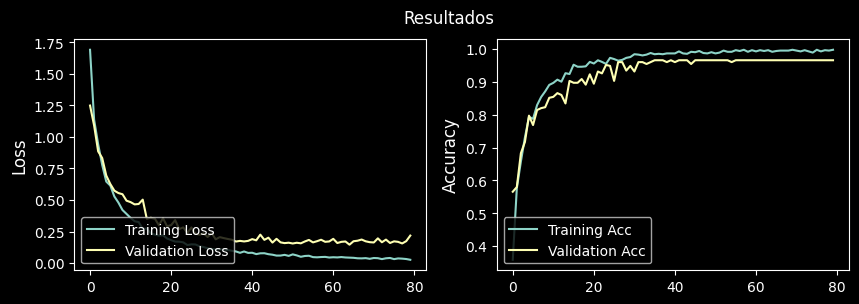

In [9]:
plt.style.use('dark_background')

plt.figure(figsize=(10,3))
plt.subplot(1, 2, 1)
plt.suptitle('Resultados', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='lower left')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=12)
plt.plot(history.history['accuracy'], label='Training Acc')
plt.plot(history.history['val_accuracy'], label='Validation Acc')
plt.legend(loc='lower left')
plt.show()

## Métricas
A avaliação do modelo no conjunto de teste revela as seguintes métricas:

A precisão (precision) representa a proporção de verdadeiros positivos em relação ao total de previsões positivas. O recall indica a proporção de verdadeiros positivos em relação ao total de positivos reais na amostra. O f1-score é a média harmônica entre precisão e recall, fornecendo uma medida geral de desempenho do modelo.

As métricas individuais são apresentadas para cada classe do problema, juntamente com o suporte, que representa o número de instâncias de cada classe no conjunto de teste.

In [10]:
loss, accuracy = model.evaluate(test_images, test_labels)
print(f"Acurácia do modelo no conjunto de teste: {accuracy}")

predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = np.argmax(test_labels, axis=1)

print(classification_report(true_labels, predicted_labels))

11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 503ms/step - accuracy: 0.9817 - loss: 0.0866
Acurácia do modelo no conjunto de teste: 0.9657142758369446
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 694ms/step
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        49
           1       1.00      0.95      0.98        66
           2       0.85      1.00      0.92        34
           3       1.00      1.00      1.00        81
           4       0.92      0.92      0.92        38
           5       0.96      0.96      0.96        82

    accuracy                           0.97       350
   macro avg       0.96      0.96      0.96       350
weighted avg       0.97      0.97      0.97       350



In [11]:
model.save("modelo_salvo.h5")

print("Modelo salvo")

Modelo salvo


# Testes unitários para demonstração

In [12]:
def predict(model, img):
    """Faz previsão no modelo utilizando imagem pré-processada
    Args:
        model: modelo Keras
        img: imagem pré-processada
    Returns:
        lista de probabilidades previstas para cada emoção
    """
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]

def plot_preds(img, preds, emotion_labels):
    """Exibe a imagem e as probabilidades previstas para cada emoção
    Args:
        img: imagem no formato PIL
        preds: lista de probabilidades previstas para cada emoção
        emotion_labels: lista de rótulos de emoção
    """
    plt.figure(figsize=(8, 3))

    # Subplot para a imagem
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')

    # Subplot para o gráfico de barras
    plt.subplot(1, 2, 2)
    plt.barh(emotion_labels, preds, alpha=0.5)
    plt.xlabel('Probabilidade')
    plt.title('Probabilidades de Emoção')

    plt.tight_layout()
    plt.show()

    
# Carregar o modelo treinado
model = load_model("modelo_salvo.h5")

# Definir os rótulos de emoção
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise']

## Teste com imagens

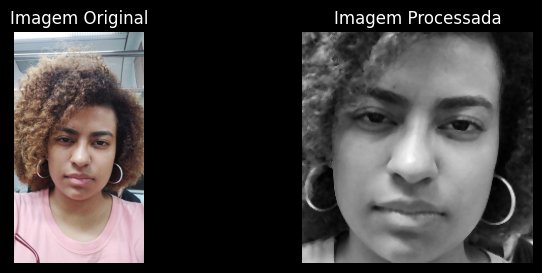

In [13]:
def preprocess(image):
    image = cut_face(image)
    
    image = cv.resize(image, (224, 224))

    image = cv.medianBlur(image, 3)

    image = mm.color(image)

    image = mm.gray(image)

    #image = improve_quality(image)
    #image = cv.equalizeHist(image)

    return image

image_path = 'testes/brava.jpg'
img = cv.imread(image_path)
image_final = preprocess(img)
cv.imwrite('image_processed.jpg', image_final)

# Plotar
plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.title('Imagem Original')
image_original = cv.imread(image_path)
plt.imshow(cv.cvtColor(image_original, cv.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Imagem Processada')
plt.imshow(image_final, cmap='gray')
plt.axis('off')

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


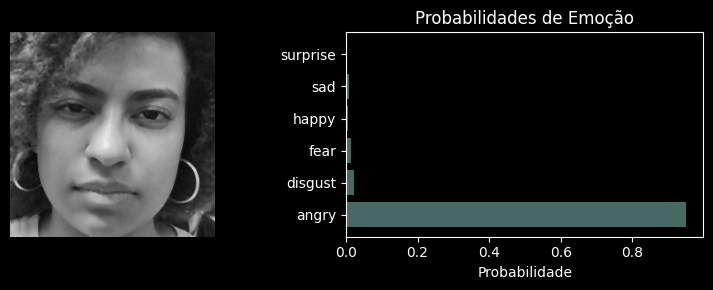

In [14]:
from keras.preprocessing import image 

img_path = 'image_processed.jpg'
img = image.load_img(img_path, target_size=(224, 224))

preds = predict(model, img)

plot_preds(img, preds, emotion_labels)


## Teste com webcam

In [ ]:
model = load_model("modelo_salvo.h5")

face_haar_cascade = cv.CascadeClassifier('haarcascade_frontalface_default.xml')

cap = cv.VideoCapture(0)

while True:
    ret, test_img = cap.read()
    if not ret:
        continue

    gray_img = mm.color(test_img)
    gray_img = mm.gray(test_img)

    faces_detected = face_haar_cascade.detectMultiScale(gray_img, 1.32, 5)

    for (x, y, w, h) in faces_detected:
        cv.rectangle(test_img, (x, y), (x + w, y + h), (0, 255, 0), thickness=3)

        roi_gray = gray_img[y:y + h, x:x + w]
        roi_gray = cv.equalizeHist(roi_gray)
        roi_gray = cv.medianBlur(roi_gray, 3)
        roi_gray = cv.resize(roi_gray, (224, 224))
        roi_gray = mm.color(roi_gray)
        
        roi_gray = roi_gray.astype('float') / 255.0
        roi_gray = np.expand_dims(roi_gray, axis=0)

        predictions = model.predict(roi_gray)
        max_index = np.argmax(predictions[0])

        emotions = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise')
        predicted_emotion = emotions[max_index]

        cv.putText(test_img, predicted_emotion, (int(x), int(y)), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 1)

    resized_img = cv.resize(test_img, (1000, 700))
    cv.imshow('Camera', resized_img)

    if cv.waitKey(1) == ord('q'):
        break

cap.release()
cv.destroyAllWindows

# Conclusões

Durante a execução deste projeto de processamento de imagens digitais e implementação de uma rede neural convolucional para avaliação de expressões emocionais, tive algumas observações e dificuldades no processo.

Inicialmente, meu objetivo era criar um sistema capaz de identificar e classificar as emoções das pessoas com base em suas expressões faciais. Por meio da utilização de técnicas de processamento de imagens e machine learning. A rede neural convolucional treinada demonstrou certa instabilidade, porém ao decorrer do projeto, com aperfeiçoamento das imagens, se tornou mais sólida em reconhecer as expressões faciais.

Mas tive certas dificuldades também. Por exemplo, algumas imagens são diferentes de outras, seja por brilho ou nitidez. Isso me forçou a criar certas soluções e técnicas para “padronizar” essas características para na hora de treinar o modelo, todas as imagens sejam iguais nesses aspectos. Além disso, durante a implementação da rede neural convolucional, tive muitos problemas com a arquitetura (por falta de conhecimento próprio) e com questões de hiperparâmetros e overfitting, necessitando de ajustes finos para alcançar um desempenho ótimo.

No mais, acredito que o objetivo do projeto foi cumprido e obtive o resultado que eu esperava, que era fazer a analise de expressão facial utilizando técnicas de processamento de imagem para o tratamento delas.



# Referências Bibliográficas


Grando, A. (2020). Análise facial de emoções utilizando redes neurais no contexto de uma sala de aula inteligente. Trabalho de Conclusão de Curso, Universidade de Caxias do Sul, Área do Conhecimento de Ciências Exatas e Engenharias. Disponível em: https://repositorio.ucs.br/xmlui/bitstream/handle/11338/6360/TCC%20Aldoir%20Grando.pdf?sequence=1&isAllowed=y. Acesso em 17 abr. 2024

Alzubaidi, L., Zhang, J., Humaidi, A.J. et al. Review of deep learning: concepts, CNN architectures, challenges, applications, future directions. Journal of Big Data, v. 8, n. 53, mar. 2021. Disponível em: https://doi.org/10.1186/s40537-021-00444-8. Acesso em 18 abr. 2024.